In [1]:
# This file contains readers for the data used in the project
import pandas as pd

# Data sources
# Electricity: https://porssisahko.net/tilastot
# Weather: https://www.ilmatieteenlaitos.fi/havaintojen-lataus
ep_df = pd.read_excel("Electricity_price-010121-220924.xlsx", header = 3)   # Some useless rows at the beginning of the file
ws_df = pd.read_excel('Kalajoki_Ulkokalla_wind_010121-210924.xlsx') 

# Consider 
# - taking more weather measurement locations into use
# - taking daily nuclear power production estimate into use
# - taking something else into use, try!

print(ep_df.head())
print(50*"-")
print(ws_df.head())


                 Aika  Hinta (snt/kWh)
0 2021-01-01 00:59:11            3.094
1 2021-01-01 01:59:11            3.019
2 2021-01-01 02:59:11            2.974
3 2021-01-01 03:59:11            2.941
4 2021-01-01 04:59:11            2.943
--------------------------------------------------
        Havaintoasema  Vuosi  Kuukausi  Päivä Aika [Paikallinen aika]  \
0  Kalajoki Ulkokalla   2021         1      1                   00:00   
1  Kalajoki Ulkokalla   2021         1      1                   01:00   
2  Kalajoki Ulkokalla   2021         1      1                   02:00   
3  Kalajoki Ulkokalla   2021         1      1                   03:00   
4  Kalajoki Ulkokalla   2021         1      1                   04:00   

  Keskituulen nopeus [m/s] Lämpötilan keskiarvo [°C]  
0                      6.2                         1  
1                      5.6                       0.8  
2                      4.8                       0.7  
3                        5                       0.5  
4

In [2]:
# Format the time column of the dataframes to match one another
from datetime import timedelta

ep_df['Aika'] = ep_df['Aika'] + timedelta(seconds=49)   # Need to adjust the time ever so slightly to get matching time format
print(ep_df.head())
print(50*"-")

# Rename wind data time columns to enable application of to_datetime call
ws_df['Aika [Paikallinen aika]'] = ws_df['Aika [Paikallinen aika]'].apply(lambda x: int(x.split(":")[0]))
ws_df.rename(columns={'Vuosi': 'year', 'Kuukausi': 'month', 'Päivä': 'day', 'Aika [Paikallinen aika]': 'hour'}, inplace=True)

ws_df['Aika'] = pd.to_datetime(ws_df[['year', 'month', 'day', 'hour']])
# Remove the now obsolete time-related columns and the location of weather observations
ws_df.drop(['year','month','day','hour', 'Havaintoasema'], axis=1, inplace=True)

print(ws_df.head())

                 Aika  Hinta (snt/kWh)
0 2021-01-01 01:00:00            3.094
1 2021-01-01 02:00:00            3.019
2 2021-01-01 03:00:00            2.974
3 2021-01-01 04:00:00            2.941
4 2021-01-01 05:00:00            2.943
--------------------------------------------------
  Keskituulen nopeus [m/s] Lämpötilan keskiarvo [°C]                Aika
0                      6.2                         1 2021-01-01 00:00:00
1                      5.6                       0.8 2021-01-01 01:00:00
2                      4.8                       0.7 2021-01-01 02:00:00
3                        5                       0.5 2021-01-01 03:00:00
4                      4.6                       0.4 2021-01-01 04:00:00


In [3]:
# Merge the two data sets
df = pd.merge(ep_df, ws_df, on='Aika', how='inner')
print(df.head())

                 Aika  Hinta (snt/kWh) Keskituulen nopeus [m/s]  \
0 2021-01-01 01:00:00            3.094                      5.6   
1 2021-01-01 02:00:00            3.019                      4.8   
2 2021-01-01 03:00:00            2.974                        5   
3 2021-01-01 04:00:00            2.941                      4.6   
4 2021-01-01 05:00:00            2.943                      4.9   

  Lämpötilan keskiarvo [°C]  
0                       0.8  
1                       0.7  
2                       0.5  
3                       0.4  
4                       0.4  


In [4]:
# Imputation

# First we need to change the types of columns, e.g., numerical values into float
print("Column types before transformation")
print(df.dtypes)    # Which columns need to be retyped?

# use to_numeric and coerce errors as nan values
df['Keskituulen nopeus [m/s]'] = pd.to_numeric(df['Keskituulen nopeus [m/s]'], errors='coerce')
df['Lämpötilan keskiarvo [°C]'] = pd.to_numeric(df['Lämpötilan keskiarvo [°C]'], errors='coerce')
print("\nColumn types after transformation")
print(df.dtypes)

# Keep it simple, replace missing values with column median
nan_count = df.isna().sum()
print("\nNAN check for columns:")
print(nan_count)
# Wind speed and temperature need imputation
df[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]']] = df[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]']].fillna(df[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]']].median())

Column types before transformation
Aika                         datetime64[ns]
Hinta (snt/kWh)                     float64
Keskituulen nopeus [m/s]             object
Lämpötilan keskiarvo [°C]            object
dtype: object

Column types after transformation
Aika                         datetime64[ns]
Hinta (snt/kWh)                     float64
Keskituulen nopeus [m/s]            float64
Lämpötilan keskiarvo [°C]           float64
dtype: object

NAN check for columns:
Aika                           0
Hinta (snt/kWh)                0
Keskituulen nopeus [m/s]     109
Lämpötilan keskiarvo [°C]      1
dtype: int64


In [5]:
df[df.columns[2]].name

'Keskituulen nopeus [m/s]'

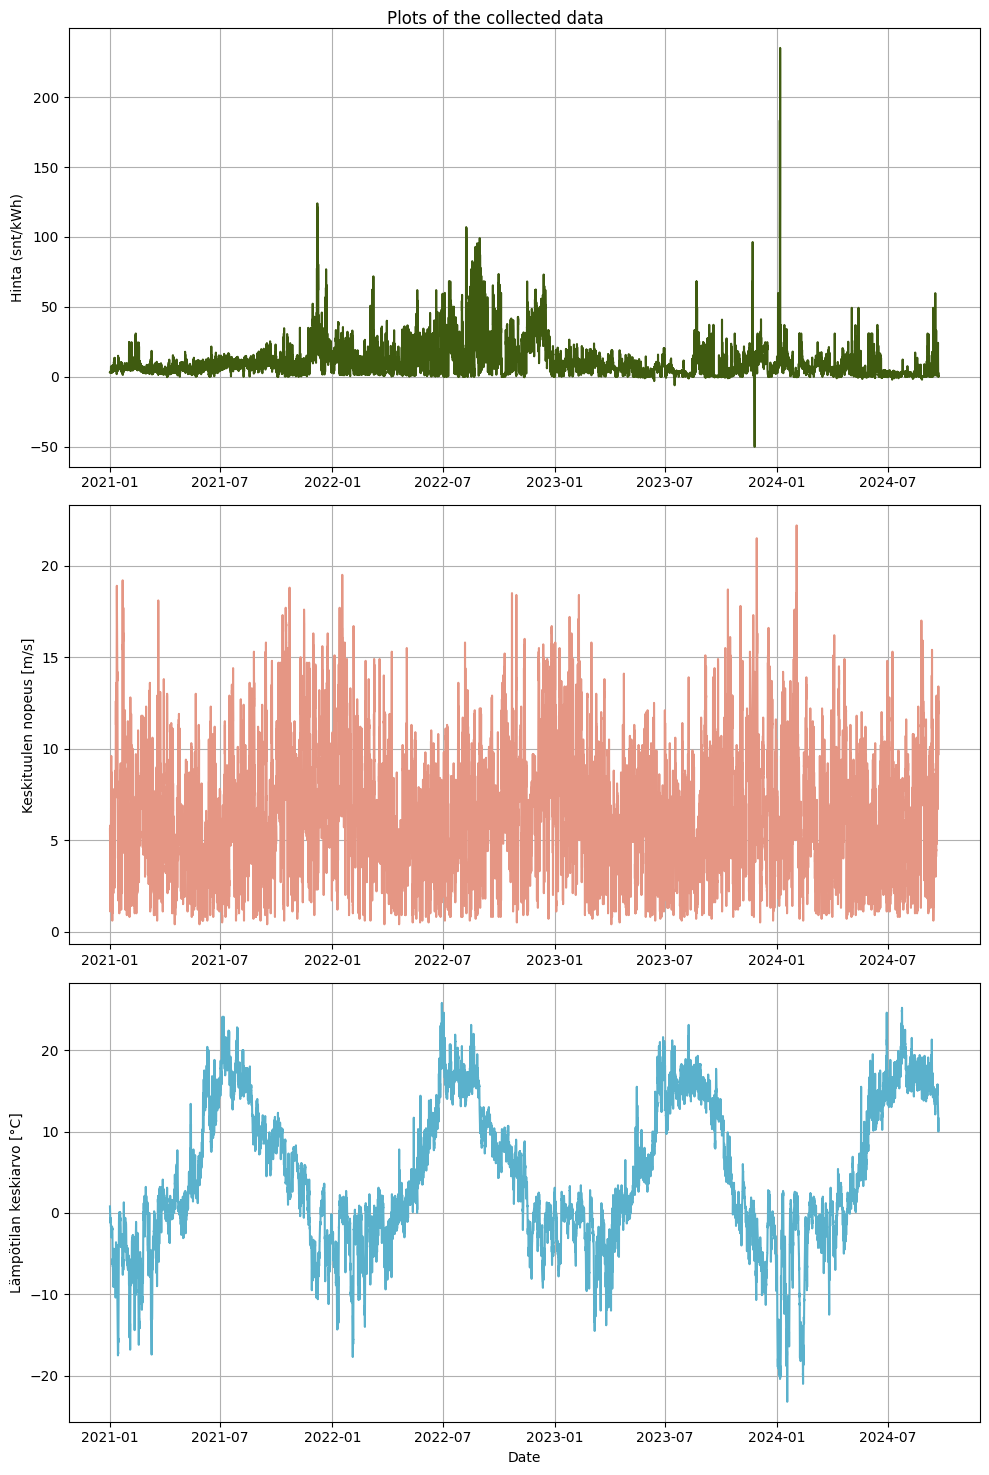

In [6]:
# Do some plotting
import matplotlib.pyplot as plt
import numpy as np

if df.index.name is None:
    # Set the index of the dataframe as the date column
    df.set_index('Aika', inplace=True)

# Helper function for generating N different colors at random so that the plots don't look so plain
def gen_random_colors(N):
    return np.random.rand(N, 3) # Return N RGB values

# Helper function for plotting all the columns of the dataframe
def print_data(df):
    N_ROWS = len(df.columns)  # Plot all columns
    color_list = gen_random_colors(N_ROWS)

    fig, axs = plt.subplots(nrows=N_ROWS, ncols=1, figsize=(10,5*N_ROWS))

    for i in range(N_ROWS):
        axs[i].plot(df.index, df[df.columns[i]], color=color_list[i])
        axs[i].set_ylabel(df.columns[i])
        axs[i].grid(True)
        if i==N_ROWS-1:
            # All xlabel to last plot 
            axs[i].set_xlabel('Date')

    fig.suptitle('Plots of the collected data')
    plt.tight_layout()
    plt.show()

print_data(df)

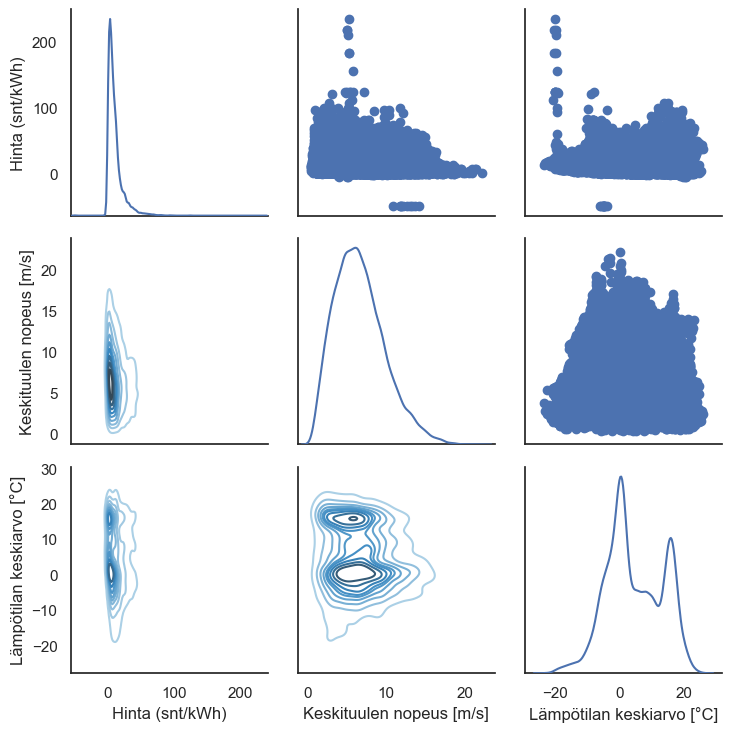

In [7]:
# Some EDA
import seaborn as sns

sns.set_theme(style="white")
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap='Blues_d')
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=1.5)

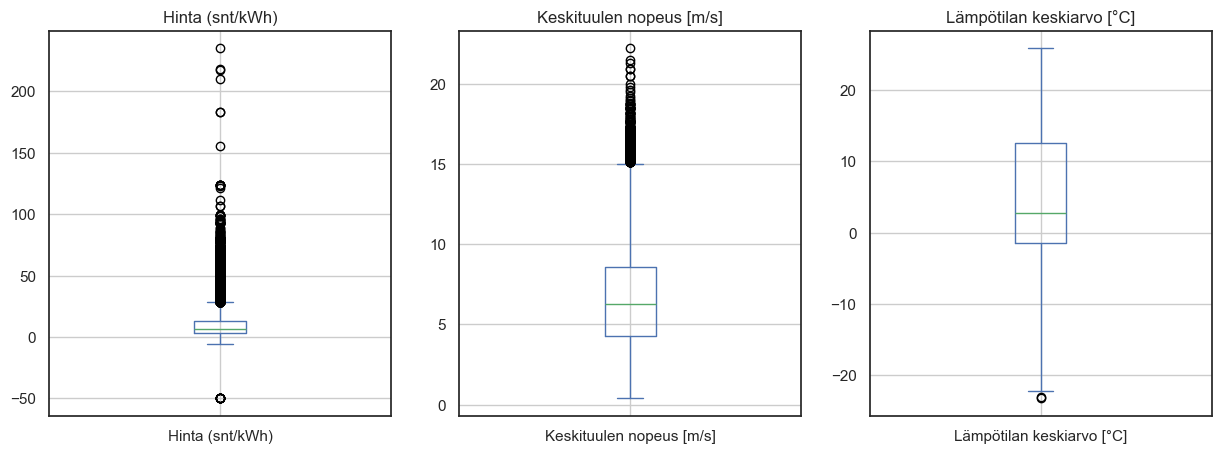

In [8]:
N_COLS = len(df.columns)
fig, axs = plt.subplots(1, 3, figsize=(5*N_COLS, 5))
for i in range(N_COLS):
    df[df.columns[i]].plot(kind='box', ax=axs[i], title=df.columns[i])
    axs[i].grid(True)

# What if all rows where price is outside of [-10,125] are pruned?

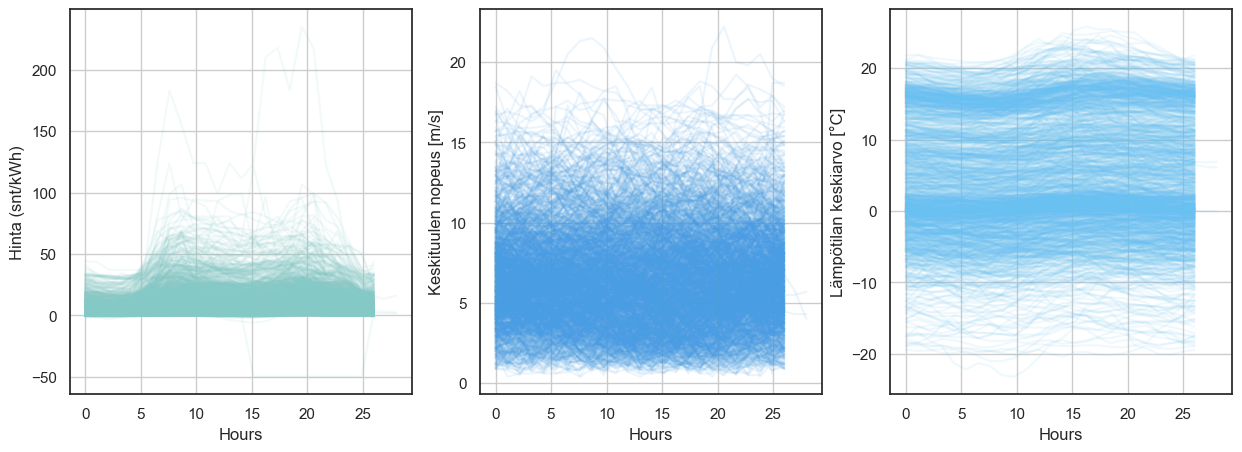

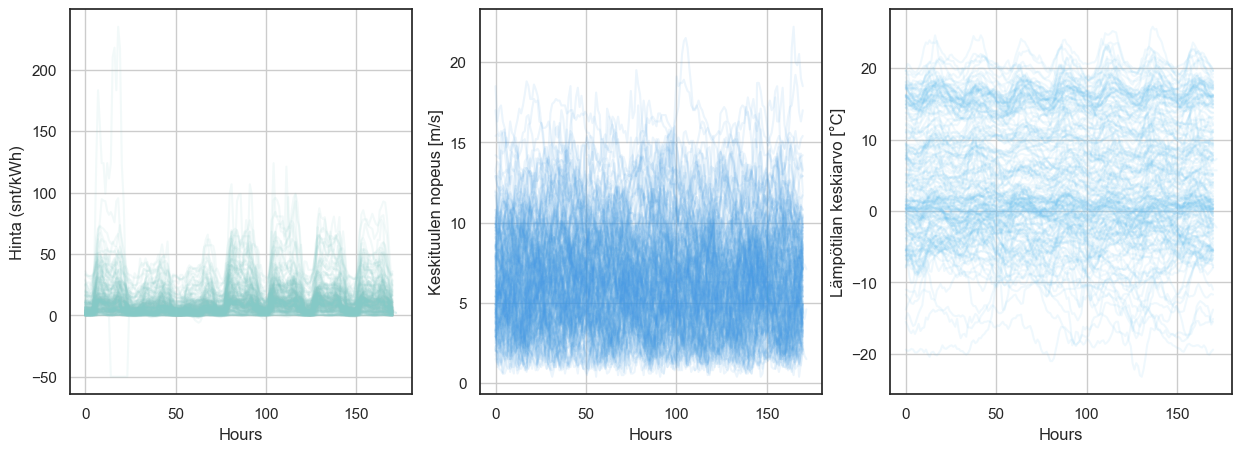

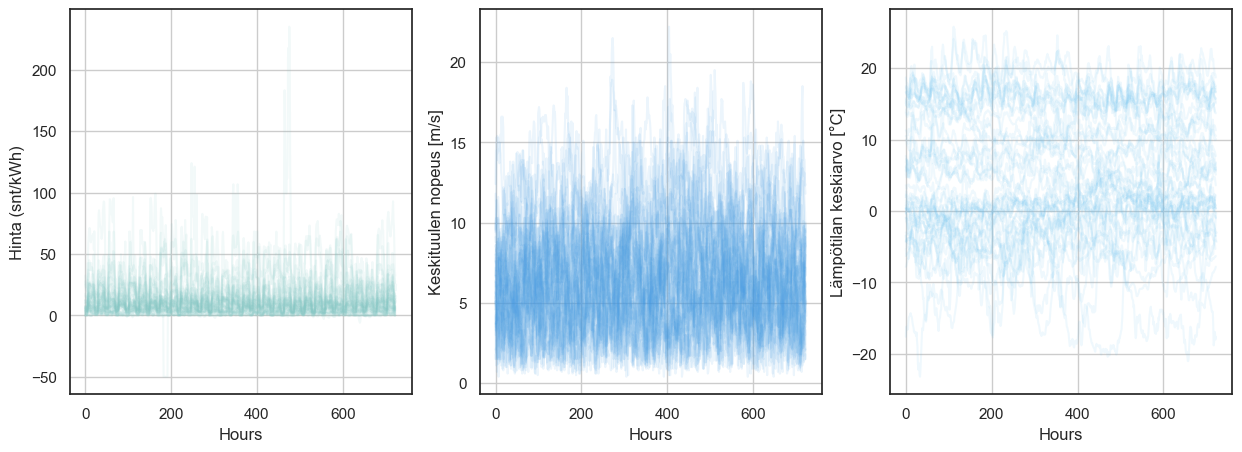

In [9]:
# What else
# plot the quantities so that each graph is one day/week/month?
# -> Helps analyzing seasonality in the data

N_COLS = len(df.columns)
color_list = gen_random_colors(N_COLS)

# Print the variables of interest by period equal to timedelta
def print_seasonally(df, timedelta):
    st_idx = df.index[0]
  
    fig, axs = plt.subplots(1,N_COLS, figsize=(5*N_COLS,5))
    while st_idx < df.index[len(df)-1]:
        if (timedelta <= df.index[len(df)-1] - st_idx):
          end_idx = st_idx + timedelta
        else:
          end_idx = df.index[len(df)-1]
        
        for i in range(N_COLS):
          n_samples = len(df[df.columns[i]][st_idx:end_idx])
          x = np.linspace(0, n_samples+1, n_samples)
          axs[i].plot(x, df[df.columns[i]][st_idx:end_idx], alpha=0.1, color=color_list[i])
          axs[i].grid(True)
          axs[i].set_ylabel(df.columns[i])
          axs[i].set_xlabel('Hours')

        st_idx = end_idx

print_seasonally(df, timedelta(days=1))
print_seasonally(df, timedelta(days=7))
print_seasonally(df, timedelta(days=30))


# Pruning: there are a few extreme outliers in the electricity price data
# - one day there was an extreme negative price in the electricity due to market operator mistake -> Can be removed with citation to a news statement related to this case
# - some day(s) there has been extreme electricity price for some hours, maybe not prunable but could be removed when trying to see relationships between the selected data

In [10]:
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Time series modeling

# Start off with just the data from 2024
df_2024 = df.loc[datetime(2024,1,1,1):]

# In fact, take two last weeks of the data set out for checking predictive performance of the model
df_2024_train = df_2024.loc[:datetime(2024,9,4)].reset_index(drop=True)
df_2024_test = df_2024.loc[datetime(2024,9,4):].reset_index(drop=True)

# Based on some web browsing, let's try a SARIMAX model
# SARIMAX
# Seasonal
# AutoRegressive
# Integrated
# Moving Average
# with eXogenous variables

price = df_2024_train['Hinta (snt/kWh)']
inputs = df_2024_train[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]']]

# The order and seasonal_order parameters should be iterated over to see which models yields the best result
model = SARIMAX(endog=price, exog=inputs, order=(1,1,1), seasonal_order=(1,1,1,24))
model_fit = model.fit()

# Check the forecast from this initial try
forecast = model_fit.forecast(steps=24, exog=df_2024_test[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]']][:24])


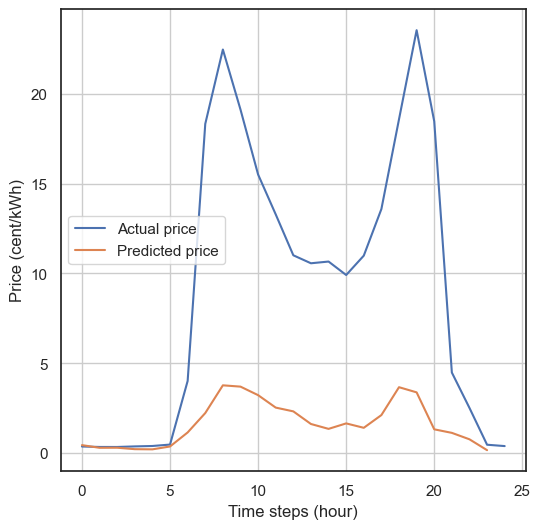

In [11]:
# Plot the prediction
df_pred = pd.DataFrame({'price': forecast}).reset_index(drop=True)

plt.figure(figsize=(6,6))
plt.plot(df_2024_test.loc[:24].index, df_2024_test.loc[:24]['Hinta (snt/kWh)'], label='Actual price')
plt.plot(df_pred.index, df_pred['price'], label='Predicted price')
plt.xlabel('Time steps (hour)')
plt.ylabel('Price (cent/kWh)')
plt.grid(True)
plt.legend()

# Scaling is off but the characteristic of the prediction seems alright....